In [2]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import pyomo.environ as pyo


**<u>LP Problem</u>**

**Example 4.6 in Book Practical chemical process optimization P. 216: Power Plant <br>**
<a href="https://ibb.co/hW5Z5R2"><img src="https://i.ibb.co/MVTGTDP/power-plant.png" alt="power-plant" border="0"></a> <br>
A power plant uses an extraction turbine that receives m<sub>s</sub> =
200 t/hr of superheated steam at 454 C and 60 atm.

the electrical power generated is given by the following equation:

P<sub>el</sub>­ (MW) = 0.4 m<sub>s</sub> – 0.38 m<sub>HP</sub> – 0.35
m<sub>LP</sub>

where m<sub>HP</sub> is the production rate of high-pressure steam
(t/hr) and m<sub>LP</sub> is the production rate of low-pressure steam
(t/hr). the operating constraint are the following:

\[1\] At least 15 t/hr of LP steam must be produced

\[2\] HL steam production of LP steam production ration must be at least
4:3.

\[3\] The maximum amount of LP and HP steam that can be produced is 50%
of the saturated steam fed to the unit.

The selling price of electricity is 0.1 \$/kWh. LP steam can be sold for
20 \$/t and HP steam for 25 \$/t. Maximize the profit of the operation

In [3]:

model = pyo.ConcreteModel()
model.mLP = pyo.Var(within=pyo.NonNegativeReals)
model.mHP = pyo.Var(within=pyo.NonNegativeReals)
model.ms = pyo.Var(within=pyo.NonNegativeReals)
model.con1 = pyo.Constraint(expr = model.mLP >= 15)
model.con2 = pyo.Constraint(expr = model.mHP + 4/3 * model.mLP >= 0)
model.con3 = pyo.Constraint(expr = model.mHP + model.mLP - 0.5* model.ms <= 0)
model.con4 = pyo.Constraint(expr = model.ms <= 200)

model.obj = pyo.Objective(expr = 0.1*(0.4* model.ms - 0.38 * model.mHP - 0.35* model.mLP) + 20* model.mLP + 25* model.mHP, sense=pyo.maximize)
status = pyo.SolverFactory('glpk').solve(model)
pyo.assert_optimal_termination(status)
model.pprint()

3 Var Declarations
    mHP : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  85.0 :  None : False : False : NonNegativeReals
    mLP : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  15.0 :  None : False : False : NonNegativeReals
    ms : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 : 200.0 :  None : False : False : NonNegativeReals

1 Objective Declarations
    obj : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : maximize : 0.1*(0.4*ms - 0.38*mHP - 0.35*mLP) + 20*mLP + 25*mHP

4 Constraint Declarations
    con1 : Size=1, Index=None, Active=True
        Key  : Lower : Body : Upper : Active
        None :  15.0 :  mLP :  +Inf :   True
    con2 : Size=1, Index=None, Active=True
        Key  : Lower : Body                         : Upper : Active
        None :   0.


**<u>CDU LP Optimization</u>** <br>
Here’s a hypothetical example of a CDU unit using 2 Crude types each yielding a different amount of products: Gasoline, Kerosene, Fuel Oil, and Residual. For each crude, there’s a different raw materials and processing costs. However, due to differences in yield, each also will have a different income. The Objective here is to create a blend or process fractions of each to generate the maximum profit. For this example, the profit will be as follows: <br>
Profit = Total Income – Total Raw Material Costs – Total Processing Costs <br>
Total Income = total income for all products (product yield * Price for each product) <br>
Total Raw material Costs = Total costs for both crudes (Amount of crude Processed*Feed Costs for each crude) <br>
Total Processing Costs = Total processing costs for both crudes (Amount of crude Processed*Feed Costs for each crude) <br>

**<u>Constraints</u>**
1. Products shouldn’t be less than Zero and not higher than max. Production specified
2. The sum of yields for all products should equal the feed rate for each crude

**Link: [Original Code Link: Pyomo Examples](https://jckantor.github.io/CBE30338/06.99-Pyomo-Examples.html)**


In [4]:

PRODUCTS = ['Gasoline', 'Kerosene', 'Gas Oil', 'Fuel Oil']
FEEDS = ['Crude 1', 'Crude 2']

products = pd.DataFrame(index=PRODUCTS)
products['Price'] = [72, 48, 42, 20]
products['Max Production'] = [24000, 2000, 6000, 100000]

crudes = pd.DataFrame(index=FEEDS)
crudes['Processing Cost'] = [1.00, 2.00]
crudes['Feed Costs'] = [48, 30]

yields = pd.DataFrame(index=PRODUCTS)
yields['Crude 1'] = [0.80, 0.05, 0.10, 0.05]
yields['Crude 2'] = [0.44, 0.10, 0.36, 0.10]

print('\n', products)
print('\n', crudes)
print('\n', yields)




           Price  Max Production
Gasoline     72           24000
Kerosene     48            2000
Gas Oil      42            6000
Fuel Oil     20          100000

          Processing Cost  Feed Costs
Crude 1              1.0          48
Crude 2              2.0          30

           Crude 1  Crude 2
Gasoline     0.80     0.44
Kerosene     0.05     0.10
Gas Oil      0.10     0.36
Fuel Oil     0.05     0.10


In [5]:


# model formulation
model = pyo.ConcreteModel()

# variables
model.x = pyo.Var(FEEDS,    domain=pyo.NonNegativeReals)
model.y = pyo.Var(PRODUCTS, domain=pyo.NonNegativeReals)
# objective
income = sum(products.loc[p, 'Price'] * model.y[p] for p in PRODUCTS)
raw_materials_cost = sum(crudes.loc[f,'Feed Costs'] * model.x[f] for f in FEEDS)



processing_cost = sum(crudes['Processing Cost'][f] * model.x[f] for f in FEEDS)

profit = income - raw_materials_cost - processing_cost
model.objective = pyo.Objective(expr = profit, sense=pyo.maximize)

# constraints
model.constraints = pyo.ConstraintList()
for p in PRODUCTS:
    model.constraints.add( model.y[p] <= products['Max Production'][p])
    model.constraints.add(0 <= model.y[p])
for p in PRODUCTS:
    model.constraints.add(model.y[p] == sum(model.x[f] * yields.loc[p,f] for f in FEEDS))

solver = pyo.SolverFactory('glpk')
solver.solve(model)
model.pprint()



2 Var Declarations
    x : Size=2, Index={Crude 1, Crude 2}
        Key     : Lower : Value            : Upper : Fixed : Stale : Domain
        Crude 1 :     0 : 26206.8965517241 :  None : False : False : NonNegativeReals
        Crude 2 :     0 : 6896.55172413793 :  None : False : False : NonNegativeReals
    y : Size=4, Index={Gasoline, Kerosene, Gas Oil, Fuel Oil}
        Key      : Lower : Value            : Upper : Fixed : Stale : Domain
        Fuel Oil :     0 :           2000.0 :  None : False : False : NonNegativeReals
         Gas Oil :     0 : 5103.44827586207 :  None : False : False : NonNegativeReals
        Gasoline :     0 :          24000.0 :  None : False : False : NonNegativeReals
        Kerosene :     0 :           2000.0 :  None : False : False : NonNegativeReals

1 Objective Declarations
    objective : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : maximize : 72*y[Gasoline] + 48*y[Kerosene] + 42*y[Gas Oil] + 

In [6]:
profit(),income(),raw_materials_cost(),processing_cost()



(573517.241379312, 2078344.8275862068, 1464827.5862068948, 39999.99999999996)

**Another Interesting Example of LP for Refinery operations**

**Eng. Emad El Gebesy: [Power of ML: Linear Programming for Refinery using Python-GEKKO](https://medium.com/@emad.elgebesy/power-of-ml-linear-programming-for-refinery-using-python-gekko-815d84bae1d5)** <br>

**<u>NLP problem</u>**

**Example 3.8 in Book Practical Chemical Process Optimization P. 141: Optimal Design of a Liquid Pumping
System** <br>
<a href="https://ibb.co/XY7phWt"><img src="https://i.ibb.co/CPbvkwQ/pumping-system.png" alt="pumping-system" border="0"></a> <br>
The basic elements of a liquid transfer system Liquid with density ρ=1000 kg/m3 and viscosity μ=0.001 kg/(ms) is to be pumped between two storage tanks that are located L=100 m apart,with flowrate Q=100 m3/h.The unit will operate for t<sub>y</sub>=8322h/y,and the cost of electricity is c<sub>el</sub>= 0.1 $/kWh.As mooth pipe is to be used with diameter between 0.03 and 0.30 m with an installed cost that depends on the diameter of the pipe used:

C<sub>pipe</sub>\[\$\] = 1500 d<sup>1.5</sup>L where L & D are in m

The equipment cost involves also the cost of the pump which is given by:

C<sub>pump</sub>\[\$\] = 750W<sup>0.3</sup> where w in kW

W is the electrical power needed to drive the pump (kW). To calculate
the electrical power, take into consideration the frictional losses
through the straight pipe:

∆P = f(L/d).0.5\*ρ\*u<sup>2</sup> where ∆P in Pa

Where u is the velocity of the liquid in the pipe and f is the moody
friction factor calculated for smooth pipe as a function of the Reynolds
number by the equation (Re \> 5000)

f = 0.316/Re<sup>0.25</sup>, Re = udρ/μ

finally if the pressure drop is known, the power to drive a pump with
efficiency ƞ<sub>e</sub> is given by:

w = Q\*∆P/ ƞ<sub>e</sub>

the aim is to select a pipe diameter so as to minimize the following
approximation total annual cost (TAC) of the piping system:

TAC = 1/3 \* (C<sub>pipe</sub>\[\$\]+C<sub>pump</sub>\[\$\]) +
wt<sub>y</sub>C<sub>el</sub> \[Objective function is to minimize this
equation)

Constraints

Diameter constraint: 0.03 ≤ d ≤ 0.3

Velocity constraint : 0 ≤ u

Reynolds Constraint: 5000 ≤ Re

Friction Factor constraint: 10<sup>-6</sup> ≤ f ≤ 0.1

dP constraint: 0 ≤ ∆P

Power constraint: 0 ≤ w

In [7]:


def velocity(d,Q):
    u = 4*Q/(np.pi*(d**2))
    return u
def Reynolds_number(d,Q,rho,mu):
    u = velocity(d,Q)
    Re = u*d*rho/mu
    return Re
def friction_factor(d,Q,rho,mu):
    u = velocity(d,Q)
    Re = Reynolds_number(d,Q,rho,mu)
    f = 0.316/(Re**0.25)
    return f 
def power_function(d,L,Q,rho,mu,eta_e):
    u = velocity(d,Q)
    f = friction_factor(d,Q,rho,mu)
    dP = f * (L/d) *0.5*rho*(u**2)
    w = Q*dP/eta_e
    return w/1000
def TAC_function_scipy(vars,L,Q,rho,mu,eta_e, ty,c_el, return_output = False):
    d = float(vars)
    w = power_function(d,L,Q,rho,mu,eta_e)
    C_pipe = 1500*(d**1.5)*L
    C_pump = 750*(w**0.3)
    TAC = (1/3)*( C_pipe+ C_pump)+w*ty*c_el

    if return_output == False:
        return TAC
    else:
        return d,w,C_pipe,C_pump,TAC




def Reynolds_constraint(x,Q,rho,mu):
    Re = Reynolds_number(x[0],Q,rho,mu)
    return Re -5000

def friction_constraint(x,Q,rho,mu,lower=True):
    Re = Reynolds_number(x[0],Q,rho,mu)
    f = 0.316/(Re**0.25)
    if lower == True:
        return 0.1 - f
    else :
        return f - 1E-06

L = 100 # length of pipe in m 
Q = 100/3600 # volumetric flowrate in m3/s
rho = 1000 # density in kg/m3
mu = 0.001 # viscosity in kg/m.s
eta_e = 0.8 # pump efficiency fractional
ty = 8322 # Operating hours per year
c_el = 0.1 # electricity cost in $/kWh


cons1 = {'type':'ineq','fun': Reynolds_constraint,'args': (Q,rho,mu)}
cons2 = {'type':'ineq','fun': friction_constraint,'args': (Q,rho,mu,True)}
cons3 = {'type':'ineq','fun': friction_constraint,'args': (Q,rho,mu,False)}
cons = [cons1,cons2,cons3]
bounds = [(0.03,0.3)]
initial_guess = [1.5]

result = minimize(TAC_function_scipy, args = (L,Q,rho,mu,eta_e, ty,c_el), x0=initial_guess, bounds = bounds, method='SLSQP', tol=0.0001, constraints =cons)
d,w,C_pipe,C_pump,TAC = TAC_function_scipy(result.x ,L,Q,rho,mu,eta_e, ty,c_el, return_output = True)

print('Optimimum diameter is {:0.2f} m or {:0.2f} inches'.format(d,d*39.37))
print('Total annual cost is {:0.2f} $/y'.format(TAC))
print('Cost of piping is {:0.2f} $/y'.format(C_pipe))
print('Cost of the pump is {:0.2f} $/y'.format(C_pump))
print('Cost of Power is {:0.2f} $/y'.format(w*ty*c_el))


Optimimum diameter is 0.13 m or 5.12 inches
Total annual cost is 3251.70 $/y
Cost of piping is 7039.91 $/y
Cost of the pump is 703.00 $/y
Cost of Power is 670.73 $/y


c:\Users\ahmed\Anaconda3\lib\site-packages\scipy\optimize\_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


In [8]:

def TAC_function(model,L,Q,rho,mu,eta_e, ty,c_el, return_output = False):
    if return_output == False :
        d = model.x
    else: d = model
    w = power_function(d,L,Q,rho,mu,eta_e)
    C_pipe = 1500*(d**1.5)*L
    C_pump = 750*(w**0.3)
    TAC = (1/3)*( C_pipe+ C_pump)+w*ty*c_el

    if return_output == False:
        return TAC
    else:
        return d,w,C_pipe,C_pump,TAC


model = pyo.ConcreteModel()
model.x = pyo.Var(initialize = 1.5)

# Setting Constraints
model.c1 = pyo.Constraint(expr = Reynolds_number(model.x,Q,rho,mu) >= 5000)
model.c2 = pyo.Constraint(expr = friction_factor( model.x,Q,rho,mu)>= 1E-6)
model.c3 = pyo.Constraint(expr = friction_factor(model.x,Q,rho,mu) <= 0.1)
# Setting Boundaries
model.x.setlb(0.03)
model.x.setub(0.3)

model.obj = pyo.Objective(rule = lambda model: TAC_function(model,L,Q,rho,mu,eta_e, ty,c_el, False), sense=pyo.minimize)

status = pyo.SolverFactory('ipopt').solve(model)
pyo.assert_optimal_termination(status)
model.pprint()
d,w,C_pipe,C_pump,TAC = TAC_function(model.x.value,L,Q,rho,mu,eta_e, ty,c_el, True)
print('Optimimum diameter is {:0.2f} m or {:0.2f} inches'.format(d,d*39.37))
print('Total annual cost is {:0.2f} $/y'.format(TAC))
print('Cost of piping is {:0.2f} $/y'.format(C_pipe))
print('Cost of the pump is {:0.2f} $/y'.format(C_pump))
print('Cost of Power is {:0.2f} $/y'.format(w*ty*c_el))

1 Var Declarations
    x : Size=1, Index=None
        Key  : Lower : Value              : Upper : Fixed : Stale : Domain
        None :  0.03 : 0.1301116337567123 :   0.3 : False : False :  Reals

1 Objective Declarations
    obj : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : minimize : 0.3333333333333333*(1500*x**1.5*100 + 750*(0.027777777777777776*(0.316/(0.1111111111111111/(3.141592653589793*x**2)*x*1000/0.001)**0.25*(100/x)*0.5*1000*(0.1111111111111111/(3.141592653589793*x**2))**2)/0.8/1000)**0.3) + 0.027777777777777776*(0.316/(0.1111111111111111/(3.141592653589793*x**2)*x*1000/0.001)**0.25*(100/x)*0.5*1000*(0.1111111111111111/(3.141592653589793*x**2))**2)/0.8/1000*8322*0.1

3 Constraint Declarations
    c1 : Size=1, Index=None, Active=True
        Key  : Lower  : Body                                                     : Upper : Active
        None : 5000.0 : 0.1111111111111111/(3.141592653589793*x**2)*x*1000/0.001 :  +Inf :

Text(0, 0.5, 'Cost in $')

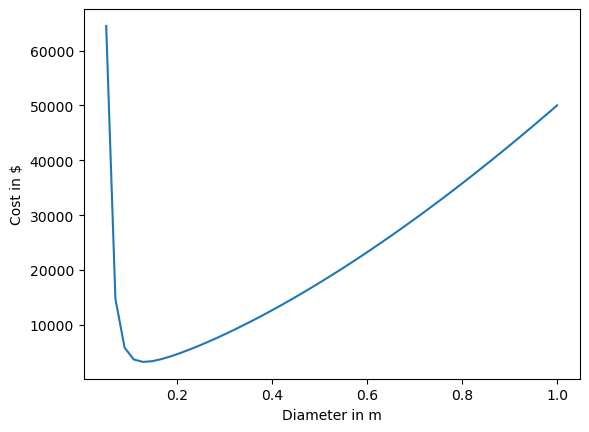

In [10]:
TAC_list = [TAC_function_scipy(i,L,Q,rho,mu,eta_e, ty,c_el, return_output = False) for i in np.linspace(0.05,1)]
import matplotlib.pyplot as plt
plt.plot(np.linspace(0.05,1),TAC_list)
plt.xlabel('Diameter in m')
plt.ylabel('Cost in $')